# Retrieving Pseudo-MPC Observations

## Objectives

## Key API References

## Import statements
In this example we do not perform an estimation, as such we only need the batchMPC class from data, environment_setup and observation to convert our observations to Tudat and optionally datetime to filter our batch. We will also use the Tudat Horizons interface to compare observation ouput and load the standard SPICE kernels.


In [1]:
from tudatpy.data.mpc import BatchMPC
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation
from tudatpy.kernel.interface import spice

from tudatpy.data.horizons import HorizonsQuery

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation, estimation_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation


# Load spice kernels
spice.load_standard_kernels()

## Retrieval

We initialise a `BatchMPC` object, create a list with the objects we want and use `.get_observations()` to retrieve the observations. `.get_observations()` uses [astroquery](https://astroquery.readthedocs.io/en/latest/mpc/mpc.html) to retrieve data from MPC and requires an internet connection. The observations are cached for faster retrieval in subsequent runs. The `BatchMPC` object removes duplicates if `.get_observations()` is ran twice.

Tudat's estimation tools allow for multiple Objects to be analysed at the same time. BatchMPC can process multiple objects into a single observation collection automatically. For now lets retrieve the observations for Eros and Svea. BatchMPC uses MPC codes for objects and observatories. To get an overview of the batch we can use the `summary()` method. Let's also get some details on some of the observatories that retrieved the data using the `observatories_table()` method.


In [10]:
from astroquery.mpc import MPC
import requests
import re
from tudatpy import constants

from astropy.time import Time
from astropy.table import Table, Column
from bs4 import BeautifulSoup
import pandas as pd

MPC.query_object = requests.get("https://www.projectpluto.com/pluto/mpecs/23053a.htm", "JUICE")
observations = MPC.query_object.text #use this if you want the whole html page
# Find the position of the <a name="stations"></a> tag
match = re.search(r'<a name="stations"></a>', observations)
if match:
    # Keep only the part of the HTML before the matched line
    html_cleaned = observations[:match.start()]
    #print(html_cleaned)
match = re.search(r'<a href="https://www.projectpluto.com/mpec_xpl.htm#astrometry"> <b>Astrometry:</b> </a>', html_cleaned)
if match:
    # Keep only the part of the HTML before the matched line
    html_cleaned = html_cleaned[match.end():].lstrip()
observations = [line.strip() for line in html_cleaned.splitlines() if line.strip()]

# Initialize lists to hold the extracted data
numbers = []
epochs = []
RAs = []
DECs = []
bands = []
observatories = []

for i,observation_string in enumerate(observations):
    soup = BeautifulSoup(observation_string, 'html.parser')

    number = i+1
    #print(f'observation n. {number}')

    # Extract the observation string (without the band and observatory)
    observation_string = soup.get_text().split(soup.find_all('a')[1].get_text())[1].split(soup.find_all('a')[2].get_text())[0].strip()
    #print(observation_string[0:3])
    if observation_string[2] == 'K' or observation_string[1] == 'B':
        #print('no can do')
        continue
    # Extract and parse date and time
    if observation_string[0:2] == 'KC' or observation_string[0:2] == '0C' or observation_string[0:2] == '3C':
        year = observation_string[2:6]  # Year (e.g., 2023)
        month = observation_string[7:9]  # Month (e.g., 04)
        date_part, frac_day = observation_string[10:19].split('.')
        #print(f'Day:{date_part}, Fraction of Day:{frac_day}')
        numbers.append(number)
    elif observation_string[0] == 'C':
        year = observation_string[1:5]  # Year (e.g., 2023)
        month = observation_string[6:8]  # Month (e.g., 04)
        date_part, frac_day = observation_string[9:18].split('.')
        #print(f'Day:{date_part}, Fraction of Day:{frac_day}')
        numbers.append(number)

    # Calculate the time in hours, minutes, seconds
    hours = float("0." + frac_day) * 24
    minutes = (hours % 1) * 60
    seconds = (minutes % 1) * 60
    #print(f'Hours:{hours}, Minutes:{minutes}, Seconds:{seconds}')
    # Convert to Julian date
    time_string = f"{date_part} {int(hours):02}:{int(minutes):02}:{round(seconds):02}"
    epoch = f'{year}-{month}-{date_part} {int(hours):02}:{int(minutes):02}:{round(seconds):02}'
    #print(f'Epoch:{epoch}')
    dt = datetime.strptime(epoch, "%Y-%m-%d %H:%M:%S")
    dt_jd = Time(dt).jd
    epochs.append(dt_jd)

    # Extract RA and DEC
    if observation_string[0:2] == 'KC' or observation_string[0:2] == '0C' or observation_string[0:2] == '3C':
        ra_dec_str = observation_string[19:45]  # RA and DEC part
        #print(f'ra & dec str:{ra_dec_str}')
        ra_part = ra_dec_str[:12].strip()  # Right Ascension
        #print(f'ra part: {ra_part}')
        dec_part = ra_dec_str[12:].strip()  # Declination (considering no space if negative)
        #print(f'dec part:{dec_part}')

        #Right Ascension
        parts_RA = ra_part.split()
        hours_RA = float(parts_RA[0])
        minutes_RA = float(parts_RA[1]) if len(parts_RA) > 1 else 0
        seconds_RA = float(parts_RA[2]) if len(parts_RA) > 2 else 0
        deg_ra = 15*hours_RA + 0.25*minutes_RA + seconds_RA/240

        #Declination
        parts_DEC = dec_part.split()
        degrees_DEC = float(parts_DEC[0])
        minutes_DEC = float(parts_DEC[1]) if len(parts_DEC) > 1 else 0
        seconds_DEC = float(parts_DEC[2]) if len(parts_DEC) > 2 else 0
        if len(parts_DEC[0]) == 3:
            deg_dec = - (abs(degrees_DEC) + minutes_DEC / 60 + seconds_DEC / 3600)
        else:
            deg_dec = (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600)
        #print(f'deg_ra {deg_ra}')
        #print(f'deg_dec {deg_dec}')
        # Extract Band
        band = observation_string[57:58]

        bands.append(band)

    elif observation_string[0] == 'C':
        ra_dec_str = observation_string[18:45]  # RA and DEC part
        #print(f'ra & dec str:{ra_dec_str}')
        ra_part = ra_dec_str[:12].strip()  # Right Ascension
        #print(f'ra part: {ra_part}')
        dec_part = ra_dec_str[12:].strip()  # Declination (considering no space if negative)
        #print(f'dec part:{dec_part}')

        #Right Ascension
        parts_RA = ra_part.split()
        hours_RA = float(parts_RA[0])
        minutes_RA = float(parts_RA[1]) if len(parts_RA) > 1 else 0
        seconds_RA = float(parts_RA[2]) if len(parts_RA) > 2 else 0
        #print(hours_RA, minutes_RA, seconds_RA)
        deg_ra = 15*hours_RA + 0.25*minutes_RA + seconds_RA/240

        #Declination
        parts_DEC = dec_part.split()
        degrees_DEC = float(parts_DEC[0])
        minutes_DEC = float(parts_DEC[1]) if len(parts_DEC) > 1 else 0
        seconds_DEC = float(parts_DEC[2]) if len(parts_DEC) > 2 else 0
        if len(parts_DEC[0]) == 3:
            deg_dec = - (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600)
        else:
            deg_dec = (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600)
        #print(f'deg_ra: {deg_ra}')
        #print(f'deg_dec {deg_dec}')
        # Extract Band
        band = observation_string[57:58]

        bands.append(band)

    # Extract the observatory code
    observatory = soup.find_all('a')[2].get_text().strip()
    observatories.append(observatory)
    RAs.append(deg_ra)
    DECs.append(deg_dec)
# Create the table
table = Table()
# Add columns to the table
table.add_column(Column(name='number', data= np.transpose(['JUICE']*len(numbers))))
table.add_column(Column(name='epoch', data=epochs))
table.add_column(Column(name='RA', data=RAs, unit='deg'))  # RA in degrees
table.add_column(Column(name='DEC', data=DECs, unit='deg'))  # DEC in degrees
table.add_column(Column(name='band', data=bands))
table.add_column(Column(name='observatory', data=observatories))

# Display the table
print(table)

batch1 = BatchMPC()
batch1.from_astropy(table)
batch1.summary()
#print(batch1.observatories_table(only_in_batch=True, only_space_telescopes=False, include_positions=False))
#print("Space Telescopes:")
#print(batch1.observatories_table(only_in_batch=True, only_space_telescopes=True, include_positions=False))

# We can also directly have a look at the the observations themselves, for example, lets take a look at the first and final observations from TESS and WISE. The table property allows for read only access to the observations in pandas dataframe format.

obs_by_Pan_STARRS = batch1.table.query("observatory == 'F51'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]
obs_by_Calar_Alto = batch1.table.query("observatory == 'Z84'").loc[:, ["number", "epochUTC", "RA", "DEC"]].iloc[[0, -1]]

#print("Initial and Final Observations by Pan_STARRS")
#print(obs_by_Pan_STARRS)
#print("Initial and Final Observations by Calar Alto-Schmidt")
#print(obs_by_Calar_Alto)

number       epoch                RA         ... band observatory
                                 deg         ...                 
------ ------------------ ------------------ ... ---- -----------
 JUICE 2460497.0859953705 333.77872916666666 ...    X         F51
 JUICE     2460497.093125 333.77964583333335 ...    X         F51
 JUICE 2460497.1002662037 333.78059583333334 ...    X         F51
 JUICE  2460497.822650463 333.99920833333334 ...    G         H21
 JUICE 2460497.8283449076  334.0001208333333 ...    G         H21
 JUICE  2460498.016412037 334.05465833333335 ...    G         T14
 JUICE  2460498.017384259  334.0547833333333 ...    G         T14
 JUICE 2460498.0183564816  334.0549041666667 ...    G         T14
 JUICE 2460498.2373032407 334.10608333333334 ...    G         Q64
   ...                ...                ... ...  ...         ...
 JUICE 2460538.4707291666 337.85266666666666 ...    G         C40
 JUICE  2460538.809201389  337.8063333333333 ...              718
 JUICE  24

In [15]:
### Retrieve Observation Collection

# List the bodies for our environment
### Set up the system of bodies
"""
A system of bodies must be created to keep observatories' positions consistent with Earth's shape model and to allow the attachment of these observatories to Earth. For the purposes of this example, we keep it as simple as possible. See the [Estimation with MPC](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/estimation_with_mpc.html) for a more complete setup and explanation appropriate for estimation. For our bodies, we only use Earth and the Sun. We set our origin to `"SSB"`, the solar system barycenter. We use the default body settings from the `SPICE` kernel to initialise the planet and use it to create a system of bodies. This system of bodies is used in the `to_tudat()` method.
"""

bodies_to_create = ["Sun", "Earth", "Moon", "Jupiter", "Saturn", "Mars", "Mercury", "Neptune", "Uranus", "Venus"]

# Create default body settings
global_frame_origin = "SSB"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)


# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

bodies.create_empty_body("JUICE")
bodies.get("JUICE").mass = 2420

# Create aerodynamic coefficient interface settings
reference_area = 100  # Average projection area of a 3U CubeSat
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0.0, 0.0]
)
# Add the aerodynamic interface to the environment
environment_setup.add_aerodynamic_coefficient_interface(bodies, "JUICE", aero_coefficient_settings)

# Create radiation pressure settings
reference_area_radiation = 100  # Average projection area of a 3U CubeSat
radiation_pressure_coefficient = 1.2
occulting_bodies = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
# Add the radiation pressure interface to the environment
environment_setup.add_radiation_pressure_interface(bodies, "JUICE", radiation_pressure_settings)

In [16]:
# Retrieve Eros' body name from BatchMPC and set its centre to enable its propapgation
bodies_to_propagate = ['JUICE']
central_bodies = [global_frame_origin]

# Now that our batch is ready, we can transform it to a Tudat `ObservationCollection` object using the `to_tudat()` method.
#
# The `.to_tudat()` does the following for us:
#
# 1. Creates an empty body for each minor planet with their MPC code as a name.
# 2. Adds this body to the system of bodies inputted to the method.
# 3. Retrieves the global position of the terrestrial observatories in the batch and adds these stations to the Tudat environment.
# 4. Creates link definitions between each unique terrestrial observatory/ minor planet combination in the batch.
# 5. (Optionally) creates a link definition between each space telescope / minor planet combination in the batch. This requires an addional input.
# 6. Creates a `SingleObservationSet` object for each unique link that includes all observations for that link.
# 7. Returns an `ObservationCollection` object.
# 7. Returns an `ObservationCollection` object.
#
# If our batch includes space telescopes like WISE and TESS we must either link their Tudat name or exclude them. For now we exclude them by setting `included_satellites` to `None`. The additional features section shows an example of how to link satellites to the `to_tudat()` method. The '.to_tudat()' method does not alter the batch object itself.

observation_collection = batch1.to_tudat(bodies, included_satellites=None, apply_star_catalog_debias = False)

# The names of the bodies added to the system of bodies object as well as the dates of the oldest and latest observations can be retrieved from the batch:


epoch_start = batch1.epoch_start# in seconds since J2000 TDB (Tudat default)
epoch_end = batch1.epoch_end
object_names = batch1.MPC_objects
print(object_names)

['JUICE']


In [17]:
# We can now retrieve the links from the ObservationCollection we got from `to_tudat()` and we can now create settings for these links. This is where link biases would be set, for now we just keep the settings default.

observation_settings_list = list()

link_list = list(
    observation_collection.get_link_definitions_for_observables(
        observable_type=observation.angular_position_type
    )
)

for link in link_list:
    # add optional bias settings
    observation_settings_list.append(
        observation.angular_position(link, bias_settings=None)
    )

# Retrieve MPC observation times, RA and DEC
batch_times = batch1.table.epochJ2000secondsTDB.to_list()
batch_times_utc = batch1.table.epochUTC.to_list()
batch_RA = batch1.table.RA
batch_DEC = batch1.table.DEC

print(batch_RA)

#print(batch_times_utc)

# Create Horizons query, see Horizons Documentation for more info.
JUICE_horizons_query = HorizonsQuery(
    query_id="-28",
    location="500@399",  # geocenter @ Earth
    epoch_list=batch_times,
    extended_query=True,
)

# retrieve JPL observations
jpl_observations = JUICE_horizons_query.interpolated_observations()
jpl_RA = jpl_observations[:, 1]
jpl_DEC = jpl_observations[:,2]

#print('yoo',batch_RA)
#print(batch_RA)
#print(jpl_RA)
#print(batch_DEC)
#print(jpl_DEC)
max_diff_RA = np.abs(jpl_RA - batch_RA).min()
max_diff_DEC = np.abs(jpl_DEC - batch_DEC).min()
#print("Maximum difference between Interpolated Horizons data and MPC observations:")
#print(f"Right Ascension: {np.round(max_diff_RA, 10)} rad")
#print(f"Declination: {np.round(max_diff_DEC, 10)} rad")

0     5.825538
1     5.825554
2     5.825570
3     5.829386
4     5.829402
        ...   
74    5.895652
75    5.885879
76    5.885818
77    5.885700
78    5.885643
Name: RA, Length: 79, dtype: float64


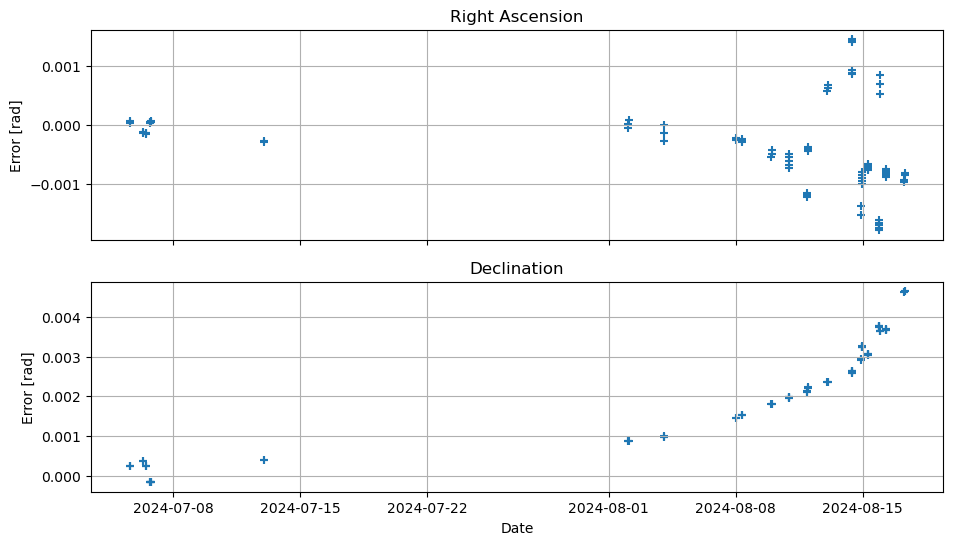

"\nThe `.plot_observations_sky()` method can be used to view a projection of the observations. Similarly, `.plot_observations_temporal()` shows the declination and right ascension of a batch's bodies over time.\n"

In [18]:
# create plot
fig, (ax_ra, ax_dec) = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

#print(f'RA residuals:\n {jpl_RA - batch_RA}')
#print(f'DEC residuals:\n + {jpl_DEC-batch_DEC}')

ax_ra.scatter(batch_times_utc, (jpl_RA - batch_RA), marker="+")
ax_dec.scatter(batch_times_utc, (jpl_DEC - batch_DEC), marker="+")

ax_ra.set_ylabel("Error [rad]")
ax_dec.set_ylabel("Error [rad]")
ax_dec.set_xlabel("Date")

ax_ra.grid()
ax_dec.grid()

ax_ra.set_title("Right Ascension")
ax_dec.set_title("Declination")

plt.show()

### Plotting observations
"""
The `.plot_observations_sky()` method can be used to view a projection of the observations. Similarly, `.plot_observations_temporal()` shows the declination and right ascension of a batch's bodies over time.
"""


# Try some of the other projections: 'hammer', 'mollweide' and 'lambert'
#fig = batch1.plot_observations_sky(projection="aitoff")
#plt.show()

#fig = batch1.plot_observations_temporal()
#plt.show()

In [20]:
# Define accelerations
accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# Set up the accelerations settings for each body, in this case only Eros
acceleration_settings = {}
for body in batch1.MPC_objects:
    print(body)
    acceleration_settings[str(body)] = accelerations

print(central_bodies)
print(bodies_to_propagate)
print(acceleration_settings)
acceleration_settings
# create the acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

JUICE
['SSB']
['JUICE']
{'JUICE': {'Sun': [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x15e813830>, <tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.RelativisticAccelerationCorrectionSettings object at 0x15e813bb0>], 'Mercury': [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x15ef5f370>], 'Venus': [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x15ef5c230>], 'Earth': [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x15ef5ffb0>], 'Moon': [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x15ef5c3f0>], 'Mars': [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x15ef5fef0>], 'Jupiter': [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.Accelera

In [8]:
# benchmark state for later comparison retrieved from SPICE
initial_states = spice.get_body_cartesian_state_at_epoch(
    target_spkid,
    global_frame_origin,
    global_frame_orientation,
    "NONE",
    epoch_start_buffer,
)

# Add random offset for initial guess
np.random.seed = 1

initial_position_offset = 1e6 * 1000
initial_velocity_offset = 100

initial_guess = initial_states.copy()
initial_guess[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
initial_guess[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

print("Error between the real initial state and our initial guess:")
print(initial_guess - initial_states)

NameError: name 'target_spkid' is not defined

In [9]:
# set create angular_position settings for each link in the list.
observation_settings_list = list()
link_list = list(
    observation_collection.get_link_definitions_for_observables(
        observable_type=observation.angular_position_type
    )
)

for link in link_list:
    # add optional bias settings here
    observation_settings_list.append(
        observation.angular_position(link, bias_settings=None)
    )
    
# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch1.epoch_start
epoch_end_nobuffer = batch1.epoch_end

print(f'Epoch Start (no buffer): {epoch_start_nobuffer}')
print(f'Epoch End (no buffer): {epoch_end_nobuffer}')

time_buffer = 1*1 *86400

# number of iterations for our estimation
number_of_pod_iterations = 6

# timestep of 20 hours for our estimation
timestep_global = 3600

epoch_start_buffer = epoch_start_nobuffer - time_buffer 
epoch_end_buffer = epoch_end_nobuffer + time_buffer 

print(f'Epoch Start (with buffer): {epoch_start_buffer}')
print(f'Epoch End (with buffer): {epoch_end_buffer}')

# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    epoch_start_buffer,
    timestep_global,
    propagation_setup.integrator.rkf_78,
    timestep_global,
    timestep_global,
    1.0,
    1.0,
)

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)

# benchmark state for later comparison retrieved from SPICE
initial_states = spice.get_body_cartesian_state_at_epoch(
    'JUICE',
    global_frame_origin,
    global_frame_orientation,
    "NONE",
    epoch_start_buffer,
)

# Add random offset for initial guess
np.random.seed = 1

initial_position_offset = 1e6 * 1000
initial_velocity_offset = 100

initial_guess = initial_states.copy()

initial_guess[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
initial_guess[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

print("Error between the real initial state and our initial guess:")
print(initial_guess - initial_states)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=central_bodies,
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess,
    initial_time=epoch_start_buffer,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition,
)

# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(
    propagator_settings, bodies
)

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)
from tudatpy.astro import element_conversion

station_altitude = 0.0
delft_latitude = np.deg2rad(52.00667)
delft_longitude = np.deg2rad(4.35556)

# Add the ground station to the environment
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "F51",
    [station_altitude, delft_latitude, delft_longitude],
    element_conversion.geodetic_position_type)

#Set up the estimator
from tudatpy.kernel import numerical_simulation

estimator = numerical_simulation.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_settings_list,
    propagator_settings=propagator_settings,
    integrate_on_creation=True,
)

print(f'Minimum Observed Time in the Observation Collection: {min(observation_collection.concatenated_times)}')
# provide the observation collection as input, and limit number of iterations for estimation.
pod_input = estimation.EstimationInput(
    observations_and_times=observation_collection,
    convergence_checker=estimation.estimation_convergence_checker(
        maximum_iterations=number_of_pod_iterations,
    ),
)

# Set methodological options
pod_input.define_estimation_settings(reintegrate_variational_equations=True)
# Perform the estimation
pod_output = estimator.perform_estimation(pod_input)

Epoch Start (no buffer): 773460299.1840273
Epoch End (no buffer): 777152102.1829114
Epoch Start (with buffer): 773373899.1840273
Epoch End (with buffer): 777238502.1829114
Error between the real initial state and our initial guess:
[ 4.00452773e+08 -4.08227579e+08  5.43597000e+08 -7.50949528e+01
  3.84856359e+01 -6.71191507e+01]
Minimum Observed Time in the Observation Collection: 773460299.1840273
Calculating residuals and partials 158
Current residual: 6.18348
Parameter update-5.41722e+12  2.53554e+12  1.13668e+12       776255      -760092      -358169
Calculating residuals and partials 158
Current residual: 2
Parameter update-2.09387e+15  9.57868e+14  4.35215e+14  3.04412e+08  -2.9273e+08 -1.38684e+08
Calculating residuals and partials 158


Warning, detected jump in observation residual of size 3.04758 for observable type 1
Warning, detected jump in observation residual of size 3.04748 for observable type 1
Warning, detected jump in observation residual of size 3.04745 for observable type 1
Warning, detected jump in observation residual of size 3.2313 for observable type 1
Warning, detected jump in observation residual of size 3.49753 for observable type 1
Warning, detected jump in observation residual of size 3.4975 for observable type 1
Warning, detected jump in observation residual of size 3.49747 for observable type 1
Warning, detected jump in observation residual of size 3.49745 for observable type 1
Warning, detected jump in observation residual of size 3.49742 for observable type 1
Warning, detected jump in observation residual of size 3.27711 for observable type 1
Warning, detected jump in observation residual of size 3.49443 for observable type 1
Warning, detected jump in observation residual of size 3.49441 for 

RuntimeError: Error in interpolator, requesting data point outside of boundaries, requested data at 772361401.89948404 but limit values are 773373899.18402731 and 777240299.18402731

In [ ]:
# retrieve the estimated initial state.
results_final = pod_output.parameter_history[:, -1]

vector_error_initial = (np.array(initial_guess) - initial_states)[0:3]
error_magnitude_initial = np.sqrt(np.square(vector_error_initial).sum()) / 1000

vector_error_final = (np.array(results_final) - initial_states)[0:3]
error_magnitude_final = np.sqrt(np.square(vector_error_final).sum()) / 1000

print(
    f"{target_name} initial guess radial error to spice: {round(error_magnitude_initial, 2)} km"
)
print(
    f"{target_name} final radial error to spice: {round(error_magnitude_final, 2)} km"
)

In [ ]:
residual_history = pod_output.residual_history

# Number of columns and rows for our plot
number_of_columns = 2

number_of_rows = (
    int(number_of_pod_iterations / number_of_columns)
    if number_of_pod_iterations % number_of_columns == 0
    else int((number_of_pod_iterations + 1) / number_of_columns)
)

fig, axs = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(9, 3.5 * number_of_rows),
    sharex=True,
    sharey=False,
)

# We cheat a little to get an approximate year out of our times (which are in seconds since J2000)
residual_times = (
    np.array(observation_collection.concatenated_times) / (86400 * 365.25) + 2000
)


# plot the residuals, split between RA and DEC types
for idx, ax in enumerate(fig.get_axes()):
    ax.grid()
    # we take every second
    ax.scatter(
        residual_times[::2],
        residual_history[
            ::2,
            idx,
        ],
        marker="+",
        s=60,
        label="Right Ascension",
    )
    ax.scatter(
        residual_times[1::2],
        residual_history[
            1::2,
            idx,
        ],
        marker="+",
        s=60,
        label="Declination",
    )
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_title("Iteration " + str(idx + 1))

plt.tight_layout()

# add the year label for the x-axis
for col in range(number_of_columns):
    axs[int(number_of_rows - 1), col].set_xlabel("Year")

axs[0, 0].legend()

plt.show()

In [ ]:
# Corellation can be retrieved using the CovarianceAnalysisInput class:
covariance_input = estimation.CovarianceAnalysisInput(observation_collection)
covariance_output = estimator.compute_covariance(covariance_input)

correlations = covariance_output.correlations
estimated_param_names = ["x", "y", "z", "vx", "vy", "vz"]


fig, ax = plt.subplots(1, 1, figsize=(9, 7))

im = ax.imshow(correlations, cmap=cm.RdYlBu_r, vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)
ax.set_yticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)

# add numbers to each of the boxes
for i in range(len(estimated_param_names)):
    for j in range(len(estimated_param_names)):
        text = ax.text(
            j, i, round(correlations[i, j], 2), ha="center", va="center", color="w"
        )

cb = plt.colorbar(im)

ax.set_xlabel("Estimated Parameter")
ax.set_ylabel("Estimated Parameter")

fig.suptitle(f"Correlations for estimated parameters for {target_name}")

fig.set_tight_layout(True)